# Introduction

In [1]:
from src.tools.data_processing.dataLoader import DataLoader
from src.tools.data_processing.dataExplorer import DataExplorer
from src.tools.data_processing.dataHandler import DataHandler
from src.tools.machine_learning.featureSelector import FeatureSelector
from src.tools.machine_learning.dataSplit import DataSplit
from src.tools.machine_learning.algorithms import Algorithms
from src.tools.machine_learning.visualizer import Visualizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import json
with open('./parameters.json') as json_file:
    parameters = json.load(json_file)
import warnings
warnings.filterwarnings('ignore')

The purpose of this work is to formulate a Machine Learning (ML) model that points out, with reasonable precision, if a patient has a heart disease. In order do to so, a data set provided by Kaggle will be used. Next, the variables in the data set are be described:

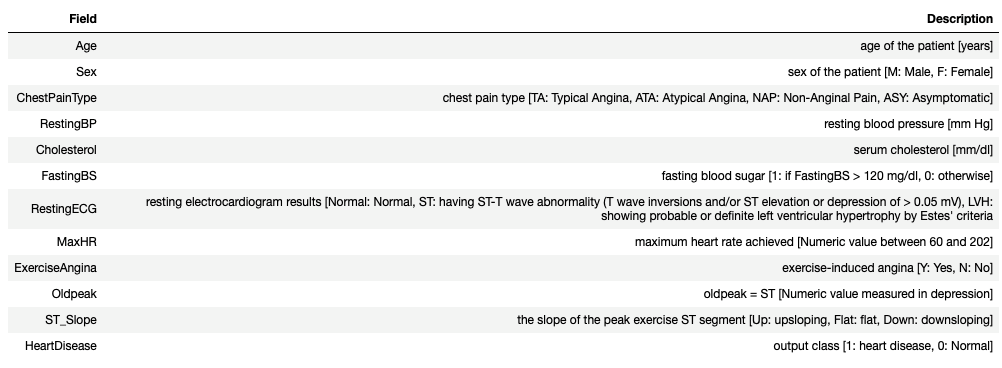

In [2]:
DataLoader("src/database/toc.png").diplay_toc()

For more details about each variable and its sources, visit **[this link](https://www.kaggle.com/fedesoriano/heart-failure-prediction?select=heart.csv)**.

# The Goal

A patient arrives at a hospital to perform a battery of tests. The machine learning model must predict if he/she has a heart disease.

#  Loading the data

The first step is to load the data set of interest:

In [3]:
database = DataLoader('src/database/heart.csv').load_data()
dp = parameters['data_processing']

Dimensionality: (918, 12)
Variables:
 Index(['Age', 'Sex', 'Chestpaintype', 'Restingbp', 'Cholesterol', 'Fastingbs',
       'Restingecg', 'Maxhr', 'Exerciseangina', 'Oldpeak', 'St_slope',
       'Heartdisease'],
      dtype='object')


The data ensemble has 918 rows and 12 columns (representing characteristics of the patients). The column HeartDisease is the one that indicates if a a patient is sick (1) or healthy (0). Therefore, the ML model must predict the value present on this column.

# Data Exploration

The variables RestingBP (resting electrocardiogram results) and Cholesterol have the following characteristics:

In [4]:
de = DataExplorer(database)
de.find_values(None)
de.find_values(0)
database = DataHandler(database).drop_values_from_cols(0, ["Cholesterol", "Restingbp"])

The column Restingbp has 1 values equal to 0.
The column Cholesterol has 172 values equal to 0.
The column Fastingbs has 704 values equal to 0.
The column Oldpeak has 368 values equal to 0.
The column Heartdisease has 410 values equal to 0.
(746, 12)


The fact that both columns contain the value zero suggests that this data was not collected for all the subjects. In fact, there is only a single patient for whom the variable RestingBP is zero, but there are 172 subjects for which the Cholesterol index was not registered. In order to avoid statistical aberrations, the corresponding rows were be discarded. Therefore, the total number of lines were be reduced by almost 19%.

The next step is to evaluate how the variables Chestpainyype, Fastingbs, Restingecg, Exerciseangina and St_slope are related with the target column, Heartdisease.

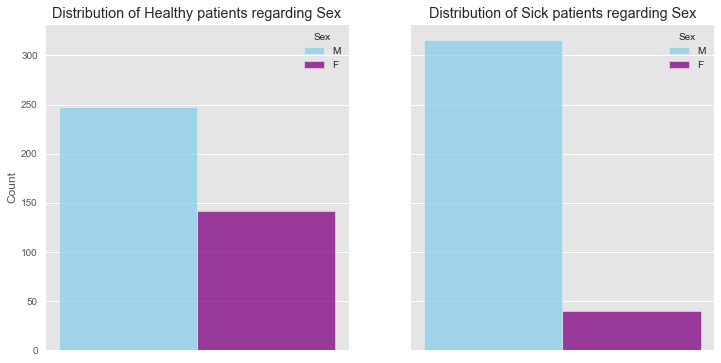

In [5]:
de = DataExplorer(database)
de.double_histogram(dp['data_vis_hist']['sex'])

The first noticeable fact is that the majority of women that seek hospitals in order to perform the exams analysed here are healthy, while the opposite is true for men. This indicates that the former group has a greater care with their personal health when compared with the later.

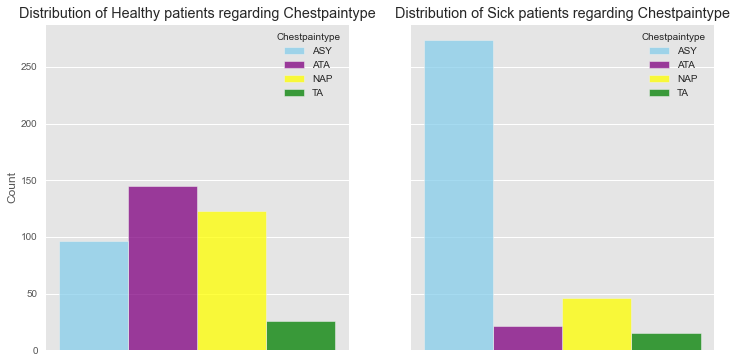

In [6]:
de.double_histogram(dp['data_vis_hist']['chestpaintype'])

Another interesting point is that the majority of asymptomatic patients in the dataset are sick. This may be an indicator that those exams are routinely sought by people during their heart disease treatment.

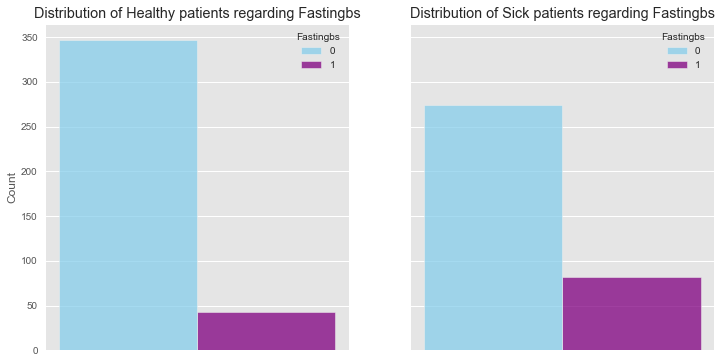

In [7]:
de.double_histogram(dp['data_vis_hist']['fastingbs'])

Furthermore, the largest part of subjects with a high concentration of sugar on their blood are sick, while the majority of the ones with normal levels are healthy. This suggests a strong link between this variable and heart diseases.

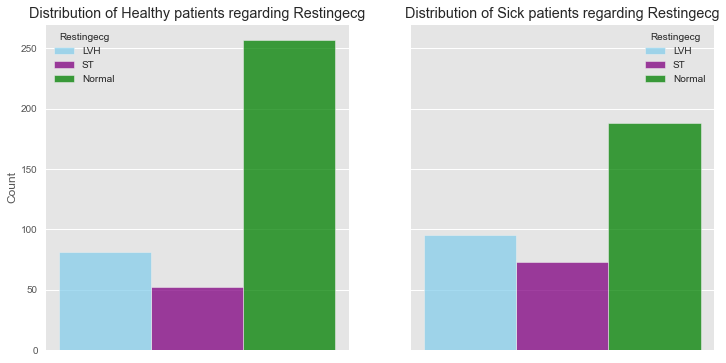

In [8]:
de.double_histogram(dp['data_vis_hist']['restingecg'])

The variable RestingECG also seems to be relevant. The majority of patients with value 'normal' for this variable are healthy, while the opposite is true.

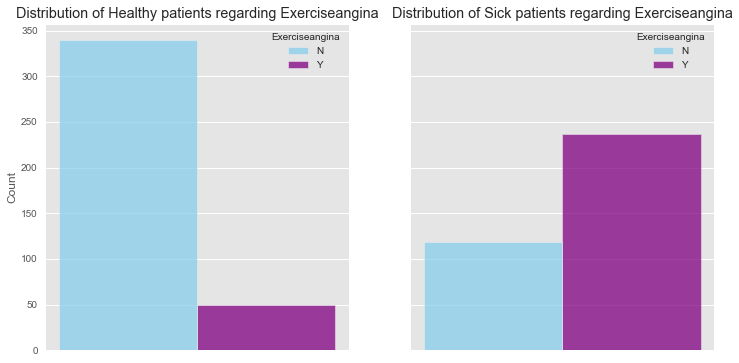

In [9]:
de.double_histogram(dp['data_vis_hist']['exerciseangina'])

Moreover, just like RestingECG, the value on the column ExerciseAngina also seems to be an important factor regarding the presence of a heart disease.

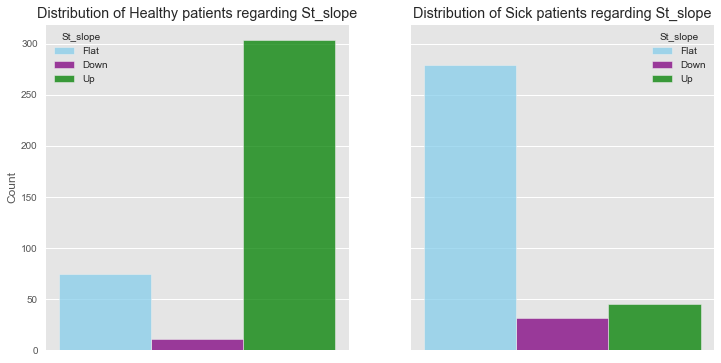

In [10]:
de.double_histogram(dp['data_vis_hist']['st_slope'])

Finally, another relevant indicator is the ST_Slope. The largest part of subjects with value 'Up' on this column are healthy, while most of the ones with 'Down' or 'Flat' values are sick.

Even tough all the variables studied so far have a qualitative nature, the data set also contains quantitative data. The relation between those and the target variable are given below:

In [11]:
de.get_correlation_table(dp["numeric_vars_corr"])

|              |        Age |   Restingbp |   Cholesterol |      Maxhr |    Oldpeak |   Heartdisease |
|:-------------|-----------:|------------:|--------------:|-----------:|-----------:|---------------:|
| Age          |  1         |   0.259865  |     0.0587582 | -0.382112  |  0.286006  |       0.298617 |
| Restingbp    |  0.259865  |   1         |     0.0959393 | -0.125774  |  0.198575  |       0.173242 |
| Cholesterol  |  0.0587582 |   0.0959393 |     1         | -0.0198558 |  0.0584881 |       0.103866 |
| Maxhr        | -0.382112  |  -0.125774  |    -0.0198558 |  1         | -0.259533  |      -0.377212 |
| Oldpeak      |  0.286006  |   0.198575  |     0.0584881 | -0.259533  |  1         |       0.495696 |
| Heartdisease |  0.298617  |   0.173242  |     0.103866  | -0.377212  |  0.495696  |       1        |

Thus, according to the criteria above, the variable Oldpeak is the one with the strongest correlation to Heart Diseases. Additionaly, despite the fact that there is no strong correlation among the predictor variables, the column 'Age' presents a weak correlation with almost all others - a negative one with MaxHR and a positive one Oldpeak and RestingBp. In fact, the correlation with the later is well known since de 80s (LONDEREE and MOESCHBERGER (1982) Effect of age and other factors on HRmax. Research Quarterly for Exercise & Sport, 53 (4), p. 297-304). On the other hand, it is interesting to notice how Cholesterol has essentially no correlation with the remaining variables.

Having finished the correlation analysis, it is important to highlight the following: correlation does not imply causality. Even if correlation can be a clue, a deeper study would have to be performed in order to establish a cause and effect relation between two variables.

# Data Manipulation

At this point, the dataset is populated by categorical and numeric variables. Thus, the first step will be to replace the categorical data by dummy variables:

In [12]:
dh = parameters['data_handling']
db = DataHandler(database).get_dummy_variables(dh['cols_to_split'])

Index(['Age', 'Restingbp', 'Cholesterol', 'Fastingbs', 'Maxhr', 'Oldpeak',
       'Heartdisease', 'Sex_F', 'Sex_M', 'Chestpaintype_ASY',
       'Chestpaintype_ATA', 'Chestpaintype_NAP', 'Chestpaintype_TA',
       'Exerciseangina_N', 'Exerciseangina_Y', 'Restingecg_LVH',
       'Restingecg_Normal', 'Restingecg_ST', 'St_slope_Down', 'St_slope_Flat',
       'St_slope_Up'],
      dtype='object')


Next, one must deal with the different scales among the variables by applying a normalization technique. This way, each variable will have values between zero and one.

In [13]:
scaled_data = DataHandler(db).min_max_cols(db.columns)

Interval of values in the dataframe: [0.0, 1.0]


Additionaly, now that all variables have a numeric nature, it is possible to analyze the correlation between all of them:

In [14]:
DataExplorer(scaled_data).get_strong_corr_predict_vars('Heartdisease', 0.5)

Corr coef between Oldpeak and Exerciseangina_Y: 0.5045401808502147
Corr coef between Exerciseangina_N and St_slope_Up: 0.5039601352344043


The strongest correlations between predictive variables are: the one between Oldpeak and Exerciseangina_Y and the one between Exerciseangina_N and St_slope_Up. Even though they are significant, they are not strong enough to justify the removal of any of them, so all variables will be kept.

With the variables selected and normalized, it is now possible to build the Machine Learning models.

# Machine Learning Models

In [15]:
ml = parameters['machine_learning']

On this section, two ML models will be created - one using linear regression and another using the random forest algorithm. In both cases, the first steps will be the same: to divide the dataset into a training and a test sets and to perform a feature selection based on the relevance of each feature.

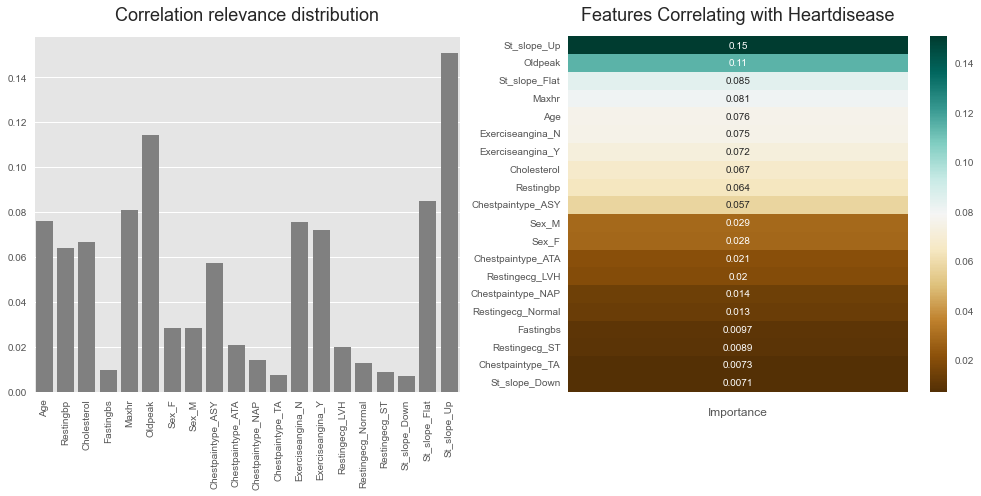

In [16]:
df = scaled_data
X = df.loc[:, df.columns != ml['target_var']]
Y = df.loc[:, df.columns == ml['target_var']]
ds = DataSplit(ml['df_test_size'])
X_train, X_test, Y_train, Y_test = ds.train_test_split(X, Y)
fs = FeatureSelector(ml['target_var'], X_train, Y_train)
fs.correlation_analysis_RandForest(ml['ntrees'], log_scale = False)

Since we are working with a small data set, we will opt for not discarding any of the variables, even the ones with lowest relevance. Next, the first ML model will be built.

## Random Forest

In [17]:
data = Algorithms(X_train, X_test, Y_train, Y_test)

In order to estimate how good a ML model can be, it is useful to perform cross validation. This way, we can avoid a biased model.

In [18]:
rfc_tool = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
data.cross_val_score_classification(rfc_tool, 5)

Mean accuracy: 0.893
Mean AUC: 0.938


The results above indicate what to expect from a ML model using a Random Forest Classifier algorithm. If the model we are aboult to build present results that are very different from those, one can understand that it is biased. Next, we construct the predictive model:

In [19]:
results_rfc = data.random_forest_class_model(ml['ntrees'])

Accuracy: 0.8973214285714286


The accuracy of the model is within the a reasonable distance from the value estimated by cross validation. Therefore, we can proceed with it. It is always useful to visualize the results so, next, we plot the confusion matrix and the ROC curve.

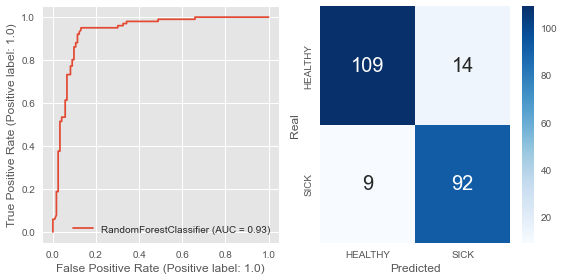

In [20]:
rfc_model = results_rfc['model']
Y_pred = results_rfc['Y_pred']
Visualizer(rfc_model).visualize_classification_results(
    X_test, Y_test, Y_pred, ml['target_var_values']
)

The AUC value shown above is very good and the confusion matrix indicates the following: the top line indicate the total amount of healthy patients. The first rectangle indicates how many of those patients were actually diagnosed as healthy, while the second one points the number diagnosed as sick. Analogously, the first rectangle on the botton line shows how many sick patients were pointed as healthy, and the second rectangle indicate how many were correctly diagnosed as sick.

With the discussion about the Random Forest algorithm closed, we can try to build a new ML model using now the Support Vector Machine approach.

## SVM

Once again, we begin with cross validation:

In [21]:
svc_tool = SVC()
data.cross_val_score_classification(svc_tool, 5)

Mean accuracy: 0.853
Mean AUC: 0.926


The results above indicate what to expect from a ML model using the Support Vector Machine algorithm. Next, we construct the predictive model itself:

In [22]:
results_svm = data.svm_model()

Accuracy: 0.8660714285714286


Once again, the accuracy of the model is within the a reasonable distance from the value estimated by cross validation, allowing us to proceed with it. The confusion matrix and the ROC curve regarding this model can be seen as follows:

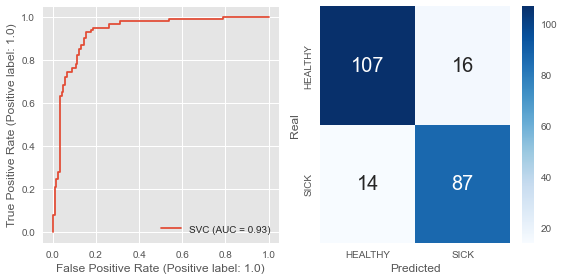

In [23]:
svm_model = results_svm['model']
Y_pred = results_svm['Y_pred']
Visualizer(svm_model).visualize_classification_results(
    X_test, Y_test, Y_pred, ml['target_var_values']
)

As it happened for the first model, the AUC value on the second model is very good. Furthermore, the interpretation of the confusion matrix is the same as the one for the Random Forest Model: the top line indicate the total amount of healthy patients. The first rectangle indicates how many of those patients were actually diagnosed as healthy, while the second one points the number diagnosed as sick. Analogously, the first rectangle on the botton line shows how many sick patients were pointed as healthy, and the second rectangle indicate how many were correctly diagnosed as sick.

# Conclusion

Both Machine Learning models constructed during this study were able to predict the presence of a heart disease in the large majority of the cases (with accuracy around 86%). Other models could be created and/or a different treatment could be applied to the original data set, but the very high value for the area under the AUC curve (above 0.9) and the accuracy found are enough for the purposes of this demonstration.